# Interpolating Between Molecules by Manipulating MolMIM Hidden States

```{note}
This notebook assumes that you have the MolMIM NIM available at the following address: `http://localhost:8000`. If your container is available at different address, you will need to modify the URL below.
```

Molecular interpolation is a technique that enables the creation of novel molecular structures by interpolating between existing molecules. This is achieved by training a generative AI model on a dataset of molecules and then using the model to generate new molecules that are a combination of the characteristics of two or more existing molecules.

In the context of drug discovery, molecular interpolation can be a powerful tool for identifying new potential drug candidates. By interpolating between two molecules that have similar properties but differ in their chemical structure, researchers can generate new molecules that retain the desirable properties of the original molecules while introducing novel features that may enhance their efficacy or reduce their toxicity.

In this notebook, we will be using the MolMIM NIM to interpolate between two JAK inhibitors, momelotinib and gandotinib. JAK inhibitors are a class of molecules that have shown promise in the treatment of various diseases, including cancer and autoimmune disorders. By interpolating between momelotinib and gandotinib, we can generate new molecules that may combine the beneficial properties of both molecules, such as improved potency, selectivity, and pharmacokinetic profiles.

We will directly manipulate the hidden states of the two JAK inhibtors to generate the interpolated hidden states, then pass these modified hidden states to the model's decoder to translate them back to SMILES strings.

We start by importing the necessary libraries.

In [1]:
import requests
import json
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt

The block below sets up the URL and headers for the request to retrieve the hidden states from the MolMIM model. It also defines the starting endpoint molecules `momelotinib` and `gandotinib` as SMILES strings.

In [2]:
# Send the request to retrieve the hidden states
url = "http://localhost:8000/hidden"
headers = {
    'accept': 'application/json',
    'Content-Type': 'application/json'
}

# Specify the starting endpoint molecules
momelotinib = Chem.CanonSmiles("C1COCCN1C2=CC=C(C=C2)NC3=NC=CC(=N3)C4=CC=C(C=C4)C(=O)NCC#N")
gandotinib = Chem.CanonSmiles("C12C(=CC(=NN1C(=C(N=2)C)CC1C(=CC(=CC=1)Cl)F)NC1=NNC(=C1)C)CN1CCOCC1")

data = {
    "sequences": [momelotinib, gandotinib]
}

The following block sends the request to the MolMIM model using the `requests` library, and extract the response as a JSON object. It then extracts the "hiddens" key from the JSON object, converts it to a NumPy array, and squeezes any singleton dimensions from the array. It also extracts the first and second rows from the array, which will be used for interpolation.

In [3]:
# Get the response from the server
response = requests.post(url, headers=headers, json=data)

# Convert the response to a JSON object
response_json = response.json()

# Extract the "hiddens" key from the JSON object
hiddens = response_json["hiddens"]

# Convert the "hiddens" array to a NumPy array
hiddens_array = np.array(hiddens)

# Squeeze any singleton dimensions from the array
hiddens_array = np.squeeze(hiddens_array)

# Extract the first and second rows from the array
row1 = hiddens_array[0]
row2 = hiddens_array[1]

The next block defines the number of interpolated molecules `n_interp` and creates an empty list `interpolated_rows` to store the interpolated vectors. It then loops through the range `n_interp` and calculates the interpolated vectors by linearly interpolating between the first and second rows. We convert the interpolated vectors to a NumPy array and expand the dimensions to match the expected input format for the decoder.

In [4]:
# Specify the number of interpolated molecules
n_interp = 50

# Generate 10 vectors that interpolate between the two rows
interpolated_rows = []
for i in range(n_interp):
    t = i / (n_interp - 1)
    interpolated_row = (1 - t) * row1 + t * row2
    interpolated_rows.append(interpolated_row)


# Convert interpolated vectors to array
interpolated_hiddens = np.expand_dims(np.array(interpolated_rows), axis=1)

The following blocks packages the interpolated hidden states into a JSON object and sends a request to the MolMIM model to decode the interpolated hidden states to SMILES strings. It then deduplicates the list of generated molecules using a dictionary, and adds the starting molecules `momelotinib` and `gandotinib` to the ends of the list. We also create a list of legends for the molecules.

In [5]:
# Package array into JSON object
interpolated_hiddens_json = {"hiddens": interpolated_hiddens.tolist(), "mask": [[True] for i in range(n_interp)]}

# Decode interpolated hidden states to SMILES strings
response = requests.post('http://localhost:8000/decode', 
                         headers={'accept': 'application/json', 'Content-Type': 'application/json'}, 
                         json=interpolated_hiddens_json)

# Deduplicate the list of generated molecules
molecules = [momelotinib] + list(dict.fromkeys(response.json()['generated'])) + [gandotinib]

# Create legends
legends = ['momelotinib'] + [f'Interpolated Molecule #{i+1}' for i in range(len(molecules) - 2)] + ['gandotinib']

In this chunk, we use the `Draw` module from RDKit to create a grid image of the molecules, with the legends and molecule names. In the output image, you can can see how the intermediate molecules share properties of each parent molecule, with either end of the spectrum being closer to respective starting molecule.

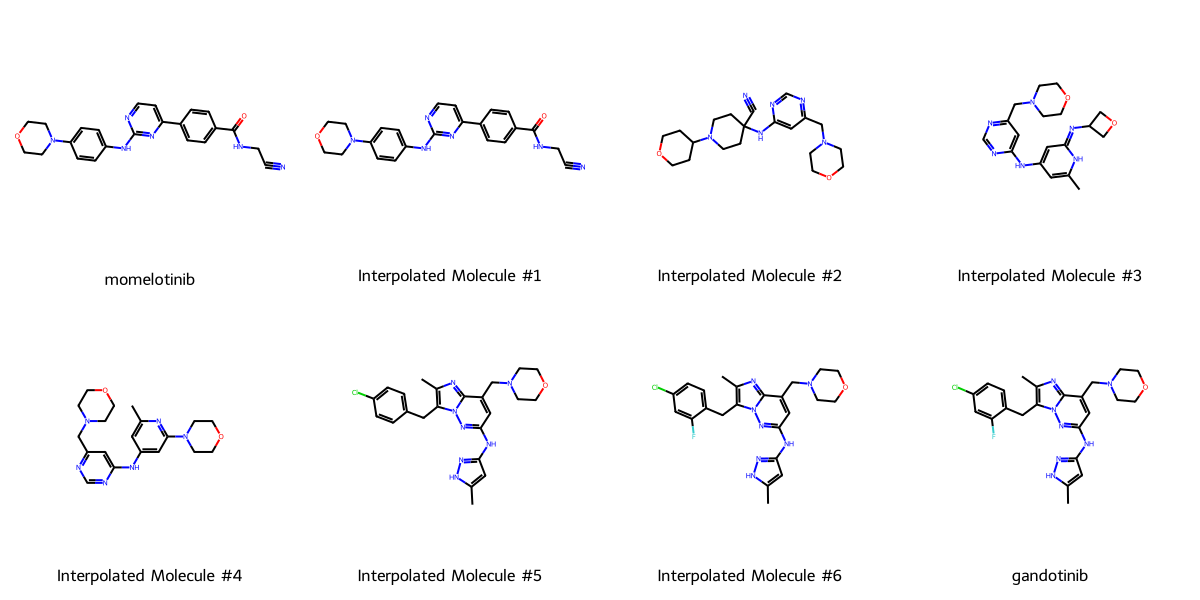

In [6]:
Draw.MolsToGridImage([Chem.MolFromSmiles(smile, sanitize=False) for smile in molecules],
                     legends=legends, molsPerRow=4, subImgSize=(300, 300))